In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import missingno as msno
from collections import Counter

import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer

# Pre-proccessing

In this notebook we prepare our data for prediction.  

We remove the variables collected at ages other than 16 and 18, change all 'object' type categories to floats and combine the 'weekend' and 'weekday' variables into total 'week' ones.  

We also deal with the missing data by applying 4 imputation methods:
+ Mean/Mode
+ KNN
+ MICE
+ NaN removal

## Raw data:

In [76]:
data = pd.read_csv("./dataset/maps-synthetic-data-v1.1.csv", engine='python')
data.head()

,Unnamed: 0,X,flag,comp_bed_9,mat_dep,mat_age,weight_16,...,creat_14,comp_games,fam_tv_eve,fam_tv_aft,fam_tv_mor,sex,birth_order
0,1,1,synthetic,NaN,3.0,30,59.294132,...,often,No,"Yes, Some Days",Other,"Yes, Every Day",Female,A
1,2,2,synthetic,NaN,9.0,26,NaN,...,NaN,NaN,NaN,NaN,NaN,Female,B
2,3,3,synthetic,NaN,3.0,24,NaN,...,NaN,NaN,"Yes, Some Days","Yes, Every Day",Other,Male,A
3,4,4,synthetic,No,NaN,22,49.812426,...,NaN,No,NaN,NaN,NaN,Male,A
4,5,5,synthetic,No,8.0,31,62.270030,...,often,No,"Yes, Some Days","Yes, Every Day","Yes, Every Day",Female,A


In [77]:
dictionary = pd.read_csv("./dataset/synthetic_data_dictionary.csv", engine='python')
dictionary.head()

,Variable Name,Variable ALSPAC Name,Variable Description,Variable Type,Administered to,Age of child at administration,ALSPAC Measure,ALSPAC Responses,Processing Details,Reference Document
0,agg_score,f596,Aggression score of partnership,Discrete,Mother,Aged 8 months,Derived by ALSPAC. See Processing Details,NaN,"Aggression score was determined by three questions: (f581) ""Does your partner get angry with you?"" (f583) ""Do you have arguments with and feelings?"" and (f585) ""Do you get angry with your partner?"". The response options for all three questions were ""Very often"", ""Often"", ""Sometimes"", ""Rarely"" and ""Never"" with the codes 1, 2, 3, 4 and 5 respectively. The codes for the three questions were summed together to calculate the score.",NaN
1,alon_week,ccs1006,Average time child spent per day doing things by yourself on a typical weekday,Ordinal,Child,Aged 198 months,"""How much time on average do you spend each day doing things by yourself on a typical weekday?""",Not at all,"The category ""Not at all"" was collapsed into the ""Less than 1 hour"" category",NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Less than 1 hour,NaN,NaN
3,,,NaN,NaN,NaN,NaN,NaN,1-2 hours,NaN,NaN
4,,,NaN,NaN,NaN,NaN,NaN,3 or more hours,NaN,NaN


Variables have different Age Of Child At Administration parameters. We don't need the variables with this parameter not equal to 16 (for variables related to screen time) and 18 (for variables related to a depression or anxiety diagnosis).

## Keeping only the columns at 16 and 18:

All vars at 16 are separated into weekend and weekdays. Might be worth summing it up into total per week.

In [78]:
index = dictionary[(dictionary["Variable Name"] == "text_week")].index
dictionary.loc[index,"Age of child at administration"] = "Aged around 15.5 years"

    Variable Name Variable ALSPAC Name  \
174  text_week     ccs1012               

                                              Variable Description  \
174  Average time child spent per day texting on a typical weekday   

    Variable Type Administered to Age of child at administration  \
174  Ordinal       Child           Aged around 15.5 years          

                                                                           ALSPAC Measure  \
174  How much time on average do you spend each day ... texting ... on a typical weekday?   

    ALSPAC Responses Processing Details Reference Document  
174  Not at all       None               NaN                


In [79]:
rows = dictionary[(dictionary["Age of child at administration"] == "Aged 198 months")]
rows2 = dictionary[(dictionary["Age of child at administration"] == "Aged around 17.5 years")]
rows3 = dictionary[(dictionary["Age of child at administration"] == "Aged around 15.5 years")]

columns_to_keep_names = list(rows['Variable Name'].append(rows2['Variable Name']).append(rows3['Variable Name']))

['alon_week', 'alon_wend', 'child_bull', 'comp_house', 'comp_int_bed_16', 'comp_noint_bed_16', 'comp_week', 'comp_wend', 'draw_week', 'draw_wend', 'exercise', 'musi_week', 'musi_wend', 'out_sum_week', 'out_sum_wend', 'out_win_week', 'out_win_wend', 'play_week', 'play_wend', 'read_week', 'read_wend', 'talk_mob_week', 'talk_mob_wend', 'talk_phon_week', 'talk_phon_wend', 'text_wend', 'tran_week', 'tran_wend', 'tv_week', 'tv_wend', 'work_week', 'work_wend', 'dep_score', 'dep_thoughts', 'has_dep_diag', 'panic_score', 'prim_diag', 'secd_diag', 'anx_band_15', 'dep_band_15', 'height_16', 'text_week', 'weight_16']


## Changing the data types:
Changing the categories to numbers and yes/no answers to 0/1

In [80]:
for i in ['comp_bed_9', 'pat_pres_10', 'pat_pres_8', 'pat_pres', 'mat_anx_1', 'mat_anx_18m', 'mat_anx_8m', 'emot_cruel',
          'phys_cruel', 'mat_anx_0m', 'child_bull', 'musi_13', 'tv_bed_9', 'own_mob', 'comp_games']:
    if(i in data.columns):
        data[i] = data[i].replace(['Yes'], 1)
        data[i] = data[i].replace(['No'], 0)
        #data[i] = data[i].fillna('5')        
    
for i in ['comp_noint_bed_16', 'comp_int_bed_16', 'comp_house', 'tv_bed_16']:
    if(i in data.columns):
        data[i] = data[i].replace(['Yes'], 1)
        data[i] = data[i].fillna(0)
    
for i in ['talk_phon_wend', 'musi_wend', 'talk_phon_week', 'musi_week']:
    if(i in data.columns):
        data[i] = data[i].replace(['Not at all'], 0)
        data[i] = data[i].replace(['Any at all'], 1)
        #data[i] = data[i].fillna('5')        

for i in ['play_wend', 'out_sum_wend', 'play_week', 'out_sum_week']:
    if(i in data.columns):
        data[i] = data[i].replace(['Less than 3 hours'], 0)
        data[i] = data[i].replace(['3 or more hours'], 1)
        #data[i] = data[i].fillna('5')        
    
for i in ['tran_wend', 'tran_week']:
    if(i in data.columns):
        data[i] = data[i].replace(['Less than 1 hour'], 0)
        data[i] = data[i].replace(['1 or more hours'], 1)
        #data[i] = data[i].fillna('5')

In [81]:
for i in ['talk_mob_wend', 'read_wend', 'draw_wend', 'talk_mob_week', 'read_week', 'draw_week']:
    if(i in data.columns):
        data[i] = data[i].replace(['Not at all', 'Less than 1 hour', '1 or more hours'], range(3))
    
for i in ['work_wend', 'alon_wend', 'out_win_wend', 'work_week', 'alon_week', 'out_win_week']:
    if(i in data.columns):
        data[i] = data[i].replace(['Less than 1 hour', '1-2 hours', '3 or more hours'], range(3))
    
for i in ['phone_14_wend', 'phone_14_week']:
    if(i in data.columns):
        data[i] = data[i].replace(['Not at all', '< 1 hour', '1 or more hours'], range(3))
    
for i in ['fam_tv_eve', 'fam_tv_aft', 'fam_tv_mor']:
    if(i in data.columns):
        data[i] = data[i].replace(['Other', 'Yes, Some Days', 'Yes, Every Day'], range(3))    

In [82]:
for i in ['text_wend', 'comp_wend', 'tv_wend', 'text_week', 'comp_week', 'tv_week']:
    if(i in data.columns):
        data[i] = data[i].replace(['Not at all', 'Less than 1 hour', '1-2 hours', '3 or more hours'], range(4))

In [83]:
percentages = ['dep_band_07', 'dep_band_15', 'dep_band_13', 'dep_band_10', 'anx_band_15', 'anx_band_07',
               'anx_band_13', 'anx_band_10']
for i in percentages:
    if(i in data.columns):
        data[i] = data[i].str.strip('%<>~').astype('float')

In [84]:
data['weight_16'].round(decimals = 2)
data['height_16'].round(decimals = 2).head()
data['has_dep_diag'].replace(['Yes ICD-10 diagnosis of depression', ' No ICD-10 diagnosis of depression'], [1, 0], inplace = True)
data['exercise'].replace(['Never','Less than once a month', '1-3 times a month',
                         '1-4 times a week', '5 or more times a week'], range(5), inplace = True)

## Combining variables
Weekend + weekday columns combines into a sum column

In [85]:
add1 = ['alon_week','draw_week','musi_week','out_sum_week','play_week','read_week','text_week',
        'tran_week','work_week','comp_week','tv_week','talk_mob_week','talk_phon_week']
add2 = ['alon_wend','draw_wend','musi_wend','out_sum_wend','play_wend','read_wend','text_wend',
        'tran_wend','work_wend','comp_wend','tv_wend','talk_mob_wend','talk_phon_wend']
add3 = ['alon','draw','musi','out_sum','play','read','text',
        'tran','work','comp','tv','talk_mob','talk_phon']

for i in range(len(add1)):
    data[add3[i]] = data[add1[i]] + data[add2[i]]

data['comp_bed_16'] = (data['comp_int_bed_16'] + data['comp_noint_bed_16'])
data['comp_house_at_all'] = (data['comp_int_bed_16'] + data['comp_noint_bed_16'] + data['comp_house'])

## Checking if combined variables were answered together


In [86]:
error = []
for i in data.index:
    for j in range(len(add1)):
        if(type(data[add1[j]][i]) != type(data[add2[j]][i])):
            if(add1[j] not in error):
                error.append(add1[j])

for i in error:
    print(i , data[i].unique())

## Remove vars at wrong ages

In [87]:
data = pd.DataFrame(data)
for i in data.columns:
    if (i not in columns_to_keep_names):
        data.drop(i, inplace = True, axis = 1)

## Missing data

In [88]:
transposed_data = data.T

In [89]:
missing_data = pd.DataFrame(data[data.columns[data.isnull().any()]].isnull().sum()/len(data)*100)

In [90]:
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 15)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

<ipython-input-90-42093ff1024d>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [91]:
names = []
for i in range(len(missing_data)):
        names.append(missing_data.iloc[i].name)
values = []
for i in range(len(missing_data)):
        values.append(missing_data.iloc[i][0])

data_1 = {'Features': names,'% Missing Data': values}

missing_df = pd.DataFrame(data_1)

missing_df.sort_values(by = ['% Missing Data'], ascending = False)

,Features,% Missing Data
38,dep_thoughts,86.857434
37,panic_score,67.139945
36,prim_diag,67.139945
35,secd_diag,67.139945
34,has_dep_diag,67.139945
...,...,...
29,tran_week,63.419251
30,dep_band_15,61.416922
31,anx_band_15,61.387797
0,weight_16,61.038299


Dropping columns (features / variables) that have NaN values above a certain threshold

In [92]:
threshold = 50

for i in range (len(missing_df)):
  if(missing_df.iloc[i]['% Missing Data'] > threshold):

SyntaxError: unexpected EOF while parsing (<ipython-input-92-b3e157af4872>, line 5)

<AxesSubplot:xlabel='comp_noint_bed_16', ylabel='Count'>

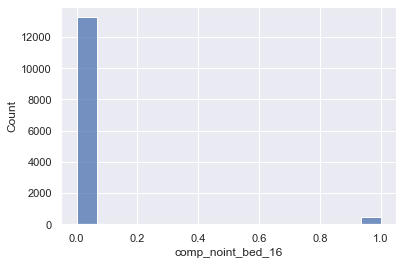

In [93]:
sns.set_theme()
sns.histplot(data.comp_noint_bed_16)

In [94]:
mean = np.mean(data.comp_week)
print("mean:", mean)
mode = stats.mode(data.comp_week)
print("mode:", mode)
median = np.median(data.comp_week)
print("median:", median)

mean: 2.041907802833766
mode: ModeResult(mode=array([2.]), count=array([2375]))
median: nan


## Export the pre-proccessed data:

In [95]:
data.to_csv("newdata2.csv")

#refined variables
remove = np.append(add1, add2)
data2 = data.drop(remove, axis = 1)

data2.to_csv('newdata3.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13734 entries, 0 to 13733
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   weight_16          5351 non-null   float64
 1   height_16          5364 non-null   float64
 2   comp_noint_bed_16  13734 non-null  float64
 3   comp_int_bed_16    13734 non-null  float64
 4   talk_phon_wend     4850 non-null   float64
 5   text_wend          4841 non-null   float64
 6   talk_mob_wend      4834 non-null   float64
 7   comp_wend          4839 non-null   float64
 8   musi_wend          4831 non-null   float64
 9   read_wend          4834 non-null   float64
 10  work_wend          4833 non-null   float64
 11  alon_wend          4850 non-null   float64
 12  draw_wend          4842 non-null   float64
 13  play_wend          4850 non-null   float64
 14  tv_wend            4853 non-null   float64
 15  out_win_wend       4849 non-null   float64
 16  out_sum_wend       482

# Getting Updated Dataset and Understanding It

In [ ]:
url = 'https://raw.githubusercontent.com/kkadzielna/project_14/main/newdata2.csv?token=GHSAT0AAAAAABSQ35YJ3OHUZPEFE3EIV2QCYSNSIRQ'
df_latest_dataset = pd.read_csv(url, index_col=0)
df_latest_dataset.head()

,weight_16,height_16,comp_noint_bed_16,comp_int_bed_16,talk_phon_wend,text_wend,talk_mob_wend,comp_wend,musi_wend,read_wend,...,anx_band_15,exercise,child_bull,has_dep_diag,secd_diag,prim_diag,panic_score,dep_thoughts,dep_score,comp_house
0,59.294132,181.602831,0.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,...,0.5,4.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0
1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,49.812426,160.224186,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,62.270030,191.703227,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,...,3.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0




> ## Insight Into Dataset



In [ ]:
for column in df_latest_dataset:
  print(df_latest_dataset[column].describe())

count    5351.000000
mean       61.720509
std        12.003745
min        32.300000
25%        53.785885
50%        59.890308
75%        67.309938
max       126.029499
Name: weight_16, dtype: float64
count    5364.000000
mean      169.286372
std         8.533072
min       139.512169
25%       163.317270
50%       168.875015
75%       175.171323
max       201.519622
Name: height_16, dtype: float64
count    13734.000000
mean         0.034294
std          0.181991
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: comp_noint_bed_16, dtype: float64
count    13734.000000
mean         0.187127
std          0.390028
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: comp_int_bed_16, dtype: float64
count    4850.000000
mean        0.735670
std         0.441021
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Na

In [ ]:
df_latest_dataset['dep_thoughts'].mode()

0    1.0
dtype: float64

# Imputations



> ## 1) First Imputed Dataset - 
Priority here is to keep record (dataset size) the same. All but "height" and "weight" variables are categorical. Therefore, "height" and "weight" (numerical) variables will be imputed using the "mean" and all other variables will be imputed using the "mode".



In [ ]:
imputed_1_dataset = df_latest_dataset.copy()

In [ ]:
imputed_1_dataset

,weight_16,height_16,comp_noint_bed_16,comp_int_bed_16,talk_phon_wend,text_wend,talk_mob_wend,comp_wend,musi_wend,read_wend,...,anx_band_15,exercise,child_bull,has_dep_diag,secd_diag,prim_diag,panic_score,dep_thoughts,dep_score,comp_house
0,59.294132,181.602831,0.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,...,0.5,4.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0
1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,49.812426,160.224186,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,62.270030,191.703227,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,...,3.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13729,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
13730,NaN,NaN,0.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,...,NaN,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
13731,58.075832,169.235565,0.0,0.0,1.0,2.0,2.0,2.0,0.0,0.0,...,15.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
13732,NaN,NaN,0.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,...,NaN,4.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0


In [ ]:
def getting_mode_from_column(column_name):
    a = df_latest_dataset[column_name].value_counts().to_frame().iloc[0].name
    a_in = float(a)
    return a_in

In [ ]:
for column in imputed_1_dataset:
    if(imputed_1_dataset[column].name == 'height_16' or imputed_1_dataset[column].name == 'weight_16'):
        imputed_1_dataset[column].fillna(value = df_latest_dataset[column].mean(), inplace = True)
    else:
        imputed_1_dataset[column].fillna(value = df_latest_dataset[column].mode().iloc[0], inplace = True)


In [ ]:
imputed_1_dataset

,weight_16,height_16,comp_noint_bed_16,comp_int_bed_16,talk_phon_wend,text_wend,talk_mob_wend,comp_wend,musi_wend,read_wend,...,anx_band_15,exercise,child_bull,has_dep_diag,secd_diag,prim_diag,panic_score,dep_thoughts,dep_score,comp_house
0,59.294132,181.602831,0.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,...,0.5,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,61.720509,169.286372,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,...,3.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,61.720509,169.286372,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,...,3.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,49.812426,160.224186,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,...,3.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,62.270030,191.703227,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,...,3.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13729,61.720509,169.286372,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,...,3.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13730,61.720509,169.286372,0.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,...,3.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13731,58.075832,169.235565,0.0,0.0,1.0,2.0,2.0,2.0,0.0,0.0,...,15.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13732,61.720509,169.286372,0.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,...,3.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
imputed_1_dataset.to_csv('imputed_dataset_1.csv')

> ## 2) Second Imputed Dataset - 
Focus here is to drop records that have 'NaN' elements in target variables. The first priority is the 'dep_score' target variable and any 'NaN' elements remaining will be further imputed (this section starts to look at multiple imputations).

In [ ]:
imputed_2_dataset = df_latest_dataset.copy()

In [ ]:
imputed_2_dataset

,weight_16,height_16,comp_noint_bed_16,comp_int_bed_16,talk_phon_wend,text_wend,talk_mob_wend,comp_wend,musi_wend,read_wend,...,anx_band_15,exercise,child_bull,has_dep_diag,secd_diag,prim_diag,panic_score,dep_thoughts,dep_score,comp_house
0,59.294132,181.602831,0.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,...,0.5,4.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0
1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,49.812426,160.224186,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,62.270030,191.703227,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,...,3.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13729,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
13730,NaN,NaN,0.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,...,NaN,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
13731,58.075832,169.235565,0.0,0.0,1.0,2.0,2.0,2.0,0.0,0.0,...,15.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
13732,NaN,NaN,0.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,...,NaN,4.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0


In [ ]:
imputed_2_dataset = imputed_2_dataset[imputed_2_dataset['dep_thoughts'].notna()]

In [ ]:
imputed_2_dataset

,weight_16,height_16,comp_noint_bed_16,comp_int_bed_16,talk_phon_wend,text_wend,talk_mob_wend,comp_wend,musi_wend,read_wend,...,anx_band_15,exercise,child_bull,has_dep_diag,secd_diag,prim_diag,panic_score,dep_thoughts,dep_score,comp_house
18,60.434027,171.252386,0.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,...,0.5,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
19,65.039715,176.972359,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,2.0,10.0,0.0,3.0,2.0,0.0
27,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,5.0,9.0,0.0,4.0,1.0,0.0
33,51.528074,168.132925,1.0,0.0,1.0,3.0,1.0,2.0,0.0,0.0,...,15.0,4.0,1.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0
49,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,4.0,12.0,0.0,4.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13701,NaN,NaN,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,...,NaN,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13710,52.587526,166.373451,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13717,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0
13720,58.307402,166.670937,0.0,1.0,0.0,1.0,0.0,3.0,1.0,1.0,...,3.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
## I2D refers to imputed_2_dataset
I2D_missing_data = pd.DataFrame(imputed_2_dataset[imputed_2_dataset.columns[imputed_2_dataset.isnull().any()]].isnull().sum()/len(imputed_2_dataset)*100)

In [ ]:
I2D_names = []
for i in range(len(I2D_missing_data)):
        I2D_names.append(I2D_missing_data.iloc[i].name)

I2D_values = []
for i in range(len(I2D_missing_data)):
        I2D_values.append(I2D_missing_data.iloc[i][0])

I2D_missing_data_dict = {'Features': I2D_names,'% Missing Data': I2D_values}

In [ ]:
df_I2D_missing_data = pd.DataFrame(I2D_missing_data_dict)

In [ ]:
len(imputed_2_dataset)

1805

In [ ]:
df_I2D_missing_data.sort_values(by = ['% Missing Data'], ascending = False)

,Features,% Missing Data
6,musi_wend,29.861496
7,read_wend,29.806094
14,out_sum_wend,29.806094
15,tran_wend,29.695291
4,talk_mob_wend,29.695291
13,out_win_wend,29.695291
5,comp_wend,29.639889
10,draw_wend,29.639889
8,work_wend,29.584488
11,play_wend,29.584488


> #### When using 'dep_score' variable we have 4513 records remaining, however, when using 'dep_thoughts' variable, we have 1805 records remaining. For the purpose of testing an array of different imputation methods, we'll stick with the 'dep_thoughts' that leaves less records behind, but overall 'NaN' elements in dataset are now significantly less.




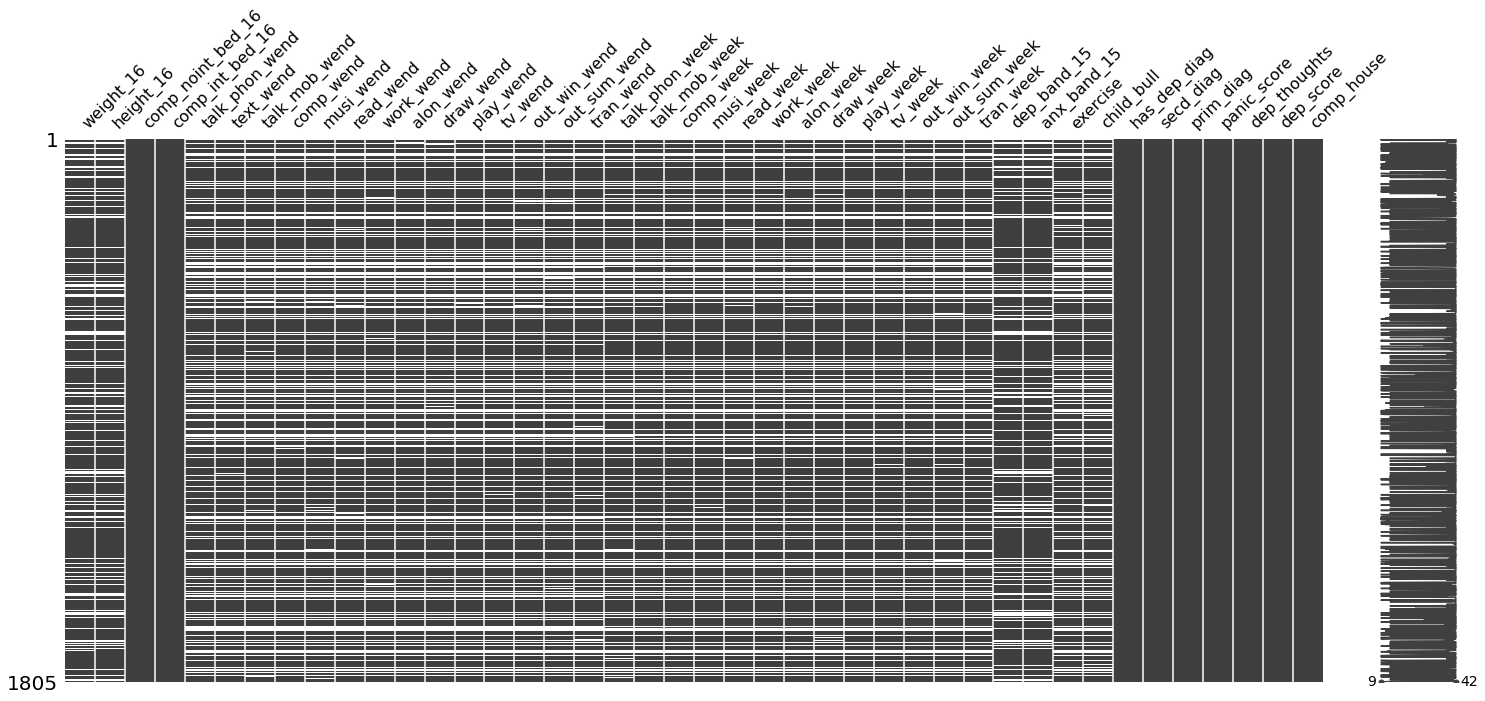

In [ ]:
msno.matrix(imputed_2_dataset)

In [ ]:
imputed_2_dataset

,weight_16,height_16,comp_noint_bed_16,comp_int_bed_16,talk_phon_wend,text_wend,talk_mob_wend,comp_wend,musi_wend,read_wend,...,anx_band_15,exercise,child_bull,has_dep_diag,secd_diag,prim_diag,panic_score,dep_thoughts,dep_score,comp_house
18,60.434027,171.252386,0.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,...,0.5,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
19,65.039715,176.972359,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,2.0,10.0,0.0,3.0,2.0,0.0
27,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,5.0,9.0,0.0,4.0,1.0,0.0
33,51.528074,168.132925,1.0,0.0,1.0,3.0,1.0,2.0,0.0,0.0,...,15.0,4.0,1.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0
49,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,4.0,12.0,0.0,4.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13701,NaN,NaN,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,...,NaN,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13710,52.587526,166.373451,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13717,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0
13720,58.307402,166.670937,0.0,1.0,0.0,1.0,0.0,3.0,1.0,1.0,...,3.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
imputed_2_dataset_with_zeros = imputed_2_dataset.fillna(0)

In [ ]:
imputed_2_dataset_with_zeros

,weight_16,height_16,comp_noint_bed_16,comp_int_bed_16,talk_phon_wend,text_wend,talk_mob_wend,comp_wend,musi_wend,read_wend,...,anx_band_15,exercise,child_bull,has_dep_diag,secd_diag,prim_diag,panic_score,dep_thoughts,dep_score,comp_house
18,60.434027,171.252386,0.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,...,0.5,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
19,65.039715,176.972359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2.0,10.0,0.0,3.0,2.0,0.0
27,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,9.0,0.0,4.0,1.0,0.0
33,51.528074,168.132925,1.0,0.0,1.0,3.0,1.0,2.0,0.0,0.0,...,15.0,4.0,1.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0
49,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,4.0,12.0,0.0,4.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13701,0.000000,0.000000,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,...,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13710,52.587526,166.373451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13717,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
13720,58.307402,166.670937,0.0,1.0,0.0,1.0,0.0,3.0,1.0,1.0,...,3.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
imputed_2_dataset_with_zeros.to_csv('imputed_dataset_2.csv')



> ##### This next step is a simple imputation that drops any record with a single 'NaN' element. This ends up leaving us with 971 records. Although it isn't expected that the size of this dataset will be sufficient for learning/ extracting meaningful features alone, it gives us an opportunity for testing "Data Augmentation", a concept in neural networks for increasing dataset "size" and creating more meaningful features for extraction.



In [ ]:
imputed_2_1_dataset_dropallna = imputed_2_dataset.dropna()

In [ ]:
imputed_2_1_dataset_dropallna

,weight_16,height_16,comp_noint_bed_16,comp_int_bed_16,talk_phon_wend,text_wend,talk_mob_wend,comp_wend,musi_wend,read_wend,...,anx_band_15,exercise,child_bull,has_dep_diag,secd_diag,prim_diag,panic_score,dep_thoughts,dep_score,comp_house
18,60.434027,171.252386,0.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,...,0.5,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
33,51.528074,168.132925,1.0,0.0,1.0,3.0,1.0,2.0,0.0,0.0,...,15.0,4.0,1.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0
66,57.894358,170.912839,0.0,1.0,1.0,2.0,2.0,0.0,1.0,0.0,...,3.0,4.0,1.0,1.0,4.0,11.0,0.0,3.0,3.0,0.0
67,79.838137,173.492735,0.0,0.0,1.0,3.0,2.0,3.0,0.0,2.0,...,3.0,3.0,0.0,0.0,2.0,8.0,0.0,3.0,2.0,1.0
77,59.650928,182.352092,0.0,0.0,0.0,2.0,0.0,3.0,1.0,2.0,...,0.5,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13582,62.004982,163.086327,0.0,1.0,1.0,2.0,2.0,3.0,0.0,0.0,...,3.0,3.0,1.0,0.0,0.0,1.0,0.0,3.0,2.0,0.0
13598,45.026119,162.539326,0.0,1.0,0.0,2.0,0.0,1.0,0.0,2.0,...,3.0,2.0,0.0,1.0,9.0,11.0,4.0,3.0,4.0,0.0
13685,47.194453,173.100118,0.0,1.0,1.0,2.0,1.0,2.0,1.0,0.0,...,0.5,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13694,49.687458,163.273265,0.0,1.0,1.0,1.0,0.0,3.0,0.0,0.0,...,3.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
imputed_2_1_dataset_dropallna.to_csv('imputed_dataset_3.csv')

> ## 3) Third Imputed Dataset - 
Here, we'll be imputing using k-means method

In [ ]:
imputed_3_dataset = df_latest_dataset.copy()

In [ ]:
for column in imputed_3_dataset:
    print(imputed_3_dataset[column].name, " :", imputed_3_dataset[column].isnull().sum())

weight_16  : 8383
height_16  : 8370
comp_noint_bed_16  : 0
comp_int_bed_16  : 0
talk_phon_wend  : 8884
text_wend  : 8893
talk_mob_wend  : 8900
comp_wend  : 8895
musi_wend  : 8903
read_wend  : 8900
work_wend  : 8901
alon_wend  : 8884
draw_wend  : 8892
play_wend  : 8884
tv_wend  : 8881
out_win_wend  : 8885
out_sum_wend  : 8912
tran_wend  : 8873
talk_phon_week  : 8735
talk_mob_week  : 8718
comp_week  : 8723
musi_week  : 8731
read_week  : 8741
work_week  : 8722
alon_week  : 8726
draw_week  : 8722
play_week  : 8719
tv_week  : 8714
out_win_week  : 8727
out_sum_week  : 8720
tran_week  : 8710
dep_band_15  : 8435
anx_band_15  : 8431
exercise  : 8763
child_bull  : 8745
has_dep_diag  : 9221
secd_diag  : 9221
prim_diag  : 9221
panic_score  : 9221
dep_thoughts  : 11929
dep_score  : 9221
comp_house  : 0


In [ ]:
## Here I'm just testing out KNN using k=3
imputer = KNNImputer(n_neighbors = 3)
imputed = imputer.fit_transform(imputed_3_dataset)

l = pd.DataFrame(imputed, columns = imputed_3_dataset.columns)

In [ ]:
for column in l:
    print(l[column].name, " :", l[column].isnull().sum())

weight_16  : 0
height_16  : 0
comp_noint_bed_16  : 0
comp_int_bed_16  : 0
talk_phon_wend  : 0
text_wend  : 0
talk_mob_wend  : 0
comp_wend  : 0
musi_wend  : 0
read_wend  : 0
work_wend  : 0
alon_wend  : 0
draw_wend  : 0
play_wend  : 0
tv_wend  : 0
out_win_wend  : 0
out_sum_wend  : 0
tran_wend  : 0
talk_phon_week  : 0
talk_mob_week  : 0
comp_week  : 0
musi_week  : 0
read_week  : 0
work_week  : 0
alon_week  : 0
draw_week  : 0
play_week  : 0
tv_week  : 0
out_win_week  : 0
out_sum_week  : 0
tran_week  : 0
dep_band_15  : 0
anx_band_15  : 0
exercise  : 0
child_bull  : 0
has_dep_diag  : 0
secd_diag  : 0
prim_diag  : 0
panic_score  : 0
dep_thoughts  : 0
dep_score  : 0
comp_house  : 0


In [ ]:
l

,weight_16,height_16,comp_noint_bed_16,comp_int_bed_16,talk_phon_wend,text_wend,talk_mob_wend,comp_wend,musi_wend,read_wend,...,anx_band_15,exercise,child_bull,has_dep_diag,secd_diag,prim_diag,panic_score,dep_thoughts,dep_score,comp_house
0,59.294132,181.602831,0.0,0.0,1.000000,1.000000,1.000000,2.000000,0.000000,1.000000,...,0.500000,4.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.333333,0.000000,1.0
1,71.016234,172.091281,0.0,0.0,1.000000,1.666667,1.333333,1.666667,0.000000,1.000000,...,1.333333,2.000000,0.000000,0.333333,0.666667,3.333333,0.0,3.666667,0.666667,0.0
2,71.016234,172.091281,0.0,0.0,1.000000,1.666667,1.333333,1.666667,0.000000,1.000000,...,1.333333,2.000000,0.000000,0.333333,0.666667,3.333333,0.0,3.666667,0.666667,0.0
3,49.812426,160.224186,0.0,0.0,0.666667,2.000000,2.000000,1.333333,0.333333,1.333333,...,7.000000,0.333333,0.333333,0.333333,3.000000,7.000000,0.0,3.000000,2.000000,0.0
4,62.270030,191.703227,1.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,...,3.000000,3.000000,0.000000,0.333333,2.666667,3.333333,0.0,3.333333,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13729,71.016234,172.091281,0.0,0.0,1.000000,1.666667,1.333333,1.666667,0.000000,1.000000,...,1.333333,2.000000,0.000000,0.333333,0.666667,3.333333,0.0,3.666667,0.666667,0.0
13730,68.213831,178.109893,0.0,0.0,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,...,2.166667,3.000000,0.000000,0.333333,2.333333,6.333333,0.0,3.666667,1.000000,0.0
13731,58.075832,169.235565,0.0,0.0,1.000000,2.000000,2.000000,2.000000,0.000000,0.000000,...,15.000000,4.000000,0.000000,0.333333,3.000000,7.000000,0.0,3.000000,1.666667,0.0
13732,55.285551,163.373018,0.0,0.0,1.000000,2.000000,0.000000,2.000000,1.000000,0.000000,...,2.166667,4.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,1.0




> #### 'Categorical_values_DA' is a categorical list for the variables "dep_band_15" and "anx_band_15". From what is apparent, the values don't look categorical and instead look continuous, but further analsis proved that all values populated in these features/variables were in the following set: [0.1, 0.5, 3, 15, 50, 70]



In [ ]:
##DA here refers to variables "dep_band_15" and "anx_band_15"
categorical_values_DA = list([0.1, 0.5, 3, 15, 50, 70])

In [ ]:
def closest (num):
    curr = categorical_values_DA[0]
    for val in categorical_values_DA:
        if abs(num - val) < abs(num - curr):
            curr = val
    return curr

In [ ]:
def rounding_anx_dep(column_name):
    for i in range(len(l[column_name])):
        replacer_val = closest(l[column_name].iloc[i])
        ##l[column].to_replace(value = replacer_val, inplace = True)
        l.loc[i, column_name] = replacer_val
    return l

In [ ]:
for column in l:
    if(l[column].name != 'height_16' and l[column].name != 'weight_16'):
        if(l[column].name != 'dep_band_15' and l[column].name != 'anx_band_15'):
            l = l.round({column: 0})
        else:
            l = rounding_anx_dep(column)
            

In [ ]:
## Can see below, fixed both "anx_band_15" and "dep_band_15" features/variables
l

,weight_16,height_16,comp_noint_bed_16,comp_int_bed_16,talk_phon_wend,text_wend,talk_mob_wend,comp_wend,musi_wend,read_wend,...,anx_band_15,exercise,child_bull,has_dep_diag,secd_diag,prim_diag,panic_score,dep_thoughts,dep_score,comp_house
0,59.294132,181.602831,0.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,...,0.5,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,71.016234,172.091281,0.0,0.0,1.0,2.0,1.0,2.0,0.0,1.0,...,0.5,2.0,0.0,0.0,1.0,3.0,0.0,4.0,1.0,0.0
2,71.016234,172.091281,0.0,0.0,1.0,2.0,1.0,2.0,0.0,1.0,...,0.5,2.0,0.0,0.0,1.0,3.0,0.0,4.0,1.0,0.0
3,49.812426,160.224186,0.0,0.0,1.0,2.0,2.0,1.0,0.0,1.0,...,3.0,0.0,0.0,0.0,3.0,7.0,0.0,3.0,2.0,0.0
4,62.270030,191.703227,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,...,3.0,3.0,0.0,0.0,3.0,3.0,0.0,3.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13729,71.016234,172.091281,0.0,0.0,1.0,2.0,1.0,2.0,0.0,1.0,...,0.5,2.0,0.0,0.0,1.0,3.0,0.0,4.0,1.0,0.0
13730,68.213831,178.109893,0.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,...,3.0,3.0,0.0,0.0,2.0,6.0,0.0,4.0,1.0,0.0
13731,58.075832,169.235565,0.0,0.0,1.0,2.0,2.0,2.0,0.0,0.0,...,15.0,4.0,0.0,0.0,3.0,7.0,0.0,3.0,2.0,0.0
13732,55.285551,163.373018,0.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,...,3.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
## Gets us 'Root Mean Square Values' RMSE between predicted output and true output
rmse = (lambda y, y_hat: np.sqrt(mean_squared_error(y, y_hat)))

In [ ]:
target_variables = ['dep_score', 'dep_thoughts', 'prim_diag', 'secd_diag', 'has_dep_diag']

In [ ]:
## Ensure the target_variable actually belong to dataset
variable_names = list(l.columns)
subset_checker = set(target_variables).issubset(set(variable_names))

if(subset_checker):
    print("'target_variables' is subset of 'variable_names'")
else:
    print("Somehthing is wrong with 'target_variables' elements")

'target_variables' is subset of 'variable_names'


In [ ]:
def optimising_k_val(targets):
    errors_K_RMSE = []
    i = 0
    for k in range(1, 20, 2):
        imputer = KNNImputer(n_neighbors = k)
        imputed = imputer.fit_transform(imputed_3_dataset)
        df_imputed = pd.DataFrame(imputed, columns = imputed_3_dataset.columns)

        X = df_imputed.drop(target_variables, axis = 1)
        y = df_imputed[target_variables]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

        model_1 = RandomForestRegressor()
        model_1.fit(X_train, y_train)
        preds = model_1.predict(X_test)
        error = rmse(y_test, preds)
        errors_K_RMSE.append({'K': k, 'RMSE': error})
        i = i + 1
        print('Done: ', i)

    return errors_K_RMSE

In [ ]:
k_RMSE_errors = optimising_k_val(target_variables)

Done:  1
Done:  2
Done:  3
Done:  4
Done:  5
Done:  6
Done:  7
Done:  8
Done:  9
Done:  10


> #### Best k-value that keeps RMSE to a minimum is K = 17



In [ ]:
k_RMSE_errors

[{'K': 1, 'RMSE': 1.348204042042837},
 {'K': 3, 'RMSE': 1.103848366118563},
 {'K': 5, 'RMSE': 0.95190453064205},
 {'K': 7, 'RMSE': 0.9282587365198163},
 {'K': 9, 'RMSE': 0.926568453994862},
 {'K': 11, 'RMSE': 0.9166571326993855},
 {'K': 13, 'RMSE': 0.9099283551803335},
 {'K': 15, 'RMSE': 0.8990701666180955},
 {'K': 17, 'RMSE': 0.898214344074769},
 {'K': 19, 'RMSE': 0.8984923442015198}]

In [ ]:
imputed_3_1_dataset = df_latest_dataset.copy()

In [ ]:
imputer = KNNImputer(n_neighbors = 17)
imputed = imputer.fit_transform(imputed_3_dataset)

l = pd.DataFrame(imputed, columns = imputed_3_dataset.columns)

In [ ]:
for column in l:
    if(l[column].name != 'height_16' and l[column].name != 'weight_16'):
        if(l[column].name != 'dep_band_15' and l[column].name != 'anx_band_15'):
            l = l.round({column: 0})
        else:
            l = rounding_anx_dep(column)


In [ ]:
l

,weight_16,height_16,comp_noint_bed_16,comp_int_bed_16,talk_phon_wend,text_wend,talk_mob_wend,comp_wend,musi_wend,read_wend,...,anx_band_15,exercise,child_bull,has_dep_diag,secd_diag,prim_diag,panic_score,dep_thoughts,dep_score,comp_house
0,59.294132,181.602831,0.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,...,0.5,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,62.290242,168.453878,0.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,...,3.0,3.0,0.0,0.0,1.0,1.0,0.0,3.0,1.0,0.0
2,62.290242,168.453878,0.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,...,3.0,3.0,0.0,0.0,1.0,1.0,0.0,3.0,1.0,0.0
3,49.812426,160.224186,0.0,0.0,1.0,2.0,1.0,2.0,0.0,1.0,...,3.0,3.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0
4,62.270030,191.703227,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,...,3.0,3.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13729,62.290242,168.453878,0.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,...,3.0,3.0,0.0,0.0,1.0,1.0,0.0,3.0,1.0,0.0
13730,58.922455,164.934872,0.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,...,3.0,3.0,0.0,0.0,1.0,2.0,0.0,2.0,0.0,0.0
13731,58.075832,169.235565,0.0,0.0,1.0,2.0,2.0,2.0,0.0,0.0,...,15.0,4.0,0.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0
13732,56.568664,171.284088,0.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,...,3.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
l.to_csv('imputed_dataset_4.csv')

> ## 4.1) Fourth-1 Imputed Dataset - 
MICE method

In [ ]:
imputed_4_dataset = df_latest_dataset.copy()

In [ ]:
imputed_4_dataset

,weight_16,height_16,comp_noint_bed_16,comp_int_bed_16,talk_phon_wend,text_wend,talk_mob_wend,comp_wend,musi_wend,read_wend,...,anx_band_15,exercise,child_bull,has_dep_diag,secd_diag,prim_diag,panic_score,dep_thoughts,dep_score,comp_house
0,59.294132,181.602831,0.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,...,0.5,4.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0
1,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,49.812426,160.224186,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,62.270030,191.703227,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,...,3.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13729,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
13730,NaN,NaN,0.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,...,NaN,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
13731,58.075832,169.235565,0.0,0.0,1.0,2.0,2.0,2.0,0.0,0.0,...,15.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
13732,NaN,NaN,0.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,...,NaN,4.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0


In [ ]:
lr = LinearRegression()
imp = IterativeImputer(estimator = lr, missing_values = np.nan, max_iter = 25, verbose = 2, imputation_order = 'roman', random_state = 0)

imputed_4_dataset = imp.fit_transform(imputed_4_dataset)

[IterativeImputer] Completing matrix with shape (13734, 42)
[IterativeImputer] Ending imputation round 1/25, elapsed time 0.70
[IterativeImputer] Change: 16.87523770345588, scaled tolerance: 0.201519621788055 
[IterativeImputer] Ending imputation round 2/25, elapsed time 1.48
[IterativeImputer] Change: 17.14428684238584, scaled tolerance: 0.201519621788055 
[IterativeImputer] Ending imputation round 3/25, elapsed time 2.41
[IterativeImputer] Change: 9.091250474803942, scaled tolerance: 0.201519621788055 
[IterativeImputer] Ending imputation round 4/25, elapsed time 3.28
[IterativeImputer] Change: 5.113965065829753, scaled tolerance: 0.201519621788055 
[IterativeImputer] Ending imputation round 5/25, elapsed time 3.99
[IterativeImputer] Change: 3.675663799200862, scaled tolerance: 0.201519621788055 
[IterativeImputer] Ending imputation round 6/25, elapsed time 4.85
[IterativeImputer] Change: 2.996910224309998, scaled tolerance: 0.201519621788055 
[IterativeImputer] Ending imputation rou

In [ ]:
imputed_4_dataset = pd.DataFrame(imputed_4_dataset)

In [ ]:
df = imputed_4_dataset.copy()
df

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,59.294132,181.602831,0.0,0.0,1.000000,1.000000,1.000000,2.000000,0.000000,1.000000,...,0.500000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.358583,0.000000,1.0
1,61.765408,169.053071,0.0,0.0,0.749674,1.620160,1.162476,2.034419,0.292091,0.774715,...,4.213265,2.807222,0.177426,0.089001,0.430322,1.330372,0.047685,1.445688,0.439730,0.0
2,61.765408,169.053071,0.0,0.0,0.749674,1.620160,1.162476,2.034419,0.292091,0.774715,...,4.213265,2.807222,0.177426,0.089001,0.430322,1.330372,0.047685,1.445688,0.439730,0.0
3,49.812426,160.224186,0.0,0.0,0.788629,1.762843,1.194766,1.940857,0.273100,0.777311,...,5.082282,2.705500,0.156432,0.108648,0.644448,1.668527,0.067058,1.697770,0.501283,0.0
4,62.270030,191.703227,1.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,...,3.000000,3.000000,0.000000,0.054213,-0.235669,0.580575,-0.007490,0.656406,0.081322,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13729,61.765408,169.053071,0.0,0.0,0.749674,1.620160,1.162476,2.034419,0.292091,0.774715,...,4.213265,2.807222,0.177426,0.089001,0.430322,1.330372,0.047685,1.445688,0.439730,0.0
13730,60.996688,171.578233,0.0,0.0,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,...,3.434424,3.000000,0.000000,0.081709,0.158065,0.936928,-0.005906,1.059937,0.373449,0.0
13731,58.075832,169.235565,0.0,0.0,1.000000,2.000000,2.000000,2.000000,0.000000,0.000000,...,15.000000,4.000000,0.000000,0.190092,1.367263,2.744449,0.104524,2.102193,0.756645,0.0
13732,56.402046,168.465770,0.0,0.0,1.000000,2.000000,0.000000,2.000000,1.000000,0.000000,...,3.461694,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.271528,0.000000,1.0


In [ ]:
i = 0
for column in df_latest_dataset:
    df.rename({i: df_latest_dataset[column].name}, inplace = True, axis = 1)
    i = i + 1

In [ ]:
df

,weight_16,height_16,comp_noint_bed_16,comp_int_bed_16,talk_phon_wend,text_wend,talk_mob_wend,comp_wend,musi_wend,read_wend,...,anx_band_15,exercise,child_bull,has_dep_diag,secd_diag,prim_diag,panic_score,dep_thoughts,dep_score,comp_house
0,59.294132,181.602831,0.0,0.0,1.000000,1.000000,1.000000,2.000000,0.000000,1.000000,...,0.500000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.358583,0.000000,1.0
1,61.765408,169.053071,0.0,0.0,0.749674,1.620160,1.162476,2.034419,0.292091,0.774715,...,4.213265,2.807222,0.177426,0.089001,0.430322,1.330372,0.047685,1.445688,0.439730,0.0
2,61.765408,169.053071,0.0,0.0,0.749674,1.620160,1.162476,2.034419,0.292091,0.774715,...,4.213265,2.807222,0.177426,0.089001,0.430322,1.330372,0.047685,1.445688,0.439730,0.0
3,49.812426,160.224186,0.0,0.0,0.788629,1.762843,1.194766,1.940857,0.273100,0.777311,...,5.082282,2.705500,0.156432,0.108648,0.644448,1.668527,0.067058,1.697770,0.501283,0.0
4,62.270030,191.703227,1.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,...,3.000000,3.000000,0.000000,0.054213,-0.235669,0.580575,-0.007490,0.656406,0.081322,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13729,61.765408,169.053071,0.0,0.0,0.749674,1.620160,1.162476,2.034419,0.292091,0.774715,...,4.213265,2.807222,0.177426,0.089001,0.430322,1.330372,0.047685,1.445688,0.439730,0.0
13730,60.996688,171.578233,0.0,0.0,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,...,3.434424,3.000000,0.000000,0.081709,0.158065,0.936928,-0.005906,1.059937,0.373449,0.0
13731,58.075832,169.235565,0.0,0.0,1.000000,2.000000,2.000000,2.000000,0.000000,0.000000,...,15.000000,4.000000,0.000000,0.190092,1.367263,2.744449,0.104524,2.102193,0.756645,0.0
13732,56.402046,168.465770,0.0,0.0,1.000000,2.000000,0.000000,2.000000,1.000000,0.000000,...,3.461694,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.271528,0.000000,1.0


In [ ]:
def rounding_anx_dep_4(column_name):
    for i in range(len(df[column_name])):
        replacer_val = closest(df[column_name].iloc[i])
        ##l[column].to_replace(value = replacer_val, inplace = True)
        df.loc[i, column_name] = replacer_val
    return df

In [ ]:
for column in df:
    if(df[column].name != 'height_16' and df[column].name != 'weight_16'):
        if(df[column].name != 'dep_band_15' and df[column].name != 'anx_band_15'):
            df = df.round({column: 0})
        else:
            df = rounding_anx_dep(column)
            

In [ ]:
df

,weight_16,height_16,comp_noint_bed_16,comp_int_bed_16,talk_phon_wend,text_wend,talk_mob_wend,comp_wend,musi_wend,read_wend,...,anx_band_15,exercise,child_bull,has_dep_diag,secd_diag,prim_diag,panic_score,dep_thoughts,dep_score,comp_house
0,59.294132,181.602831,0.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,...,0.5,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,62.290242,168.453878,0.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,...,3.0,3.0,0.0,0.0,1.0,1.0,0.0,3.0,1.0,0.0
2,62.290242,168.453878,0.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,...,3.0,3.0,0.0,0.0,1.0,1.0,0.0,3.0,1.0,0.0
3,49.812426,160.224186,0.0,0.0,1.0,2.0,1.0,2.0,0.0,1.0,...,3.0,3.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0
4,62.270030,191.703227,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,...,3.0,3.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13729,62.290242,168.453878,0.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,...,3.0,3.0,0.0,0.0,1.0,1.0,0.0,3.0,1.0,0.0
13730,58.922455,164.934872,0.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,...,3.0,3.0,0.0,0.0,1.0,2.0,0.0,2.0,0.0,0.0
13731,58.075832,169.235565,0.0,0.0,1.0,2.0,2.0,2.0,0.0,0.0,...,15.0,4.0,0.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0
13732,56.568664,171.284088,0.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,...,3.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
df.to_csv('imputed_dataset_5.csv')